# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

## EDA

In [154]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import normaltest
import scipy.stats as stats

df = pd.read_csv('data/human_body_temperature.csv')

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


In [85]:
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


## 1: Is the distribution of body temperatures normal?

1) Data represents a Gaussian curve, where the mean value has similarly mirrored distributions on either side, shown directly below. Looking at the ecdf, it also appears to show normality with the distribution of body temperatures.

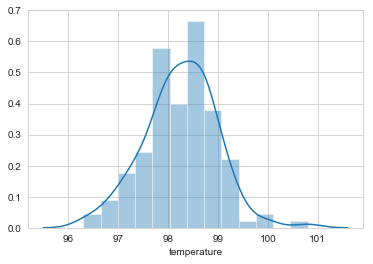

In [88]:
_ = sns.distplot(df['temperature'])
plt.show()

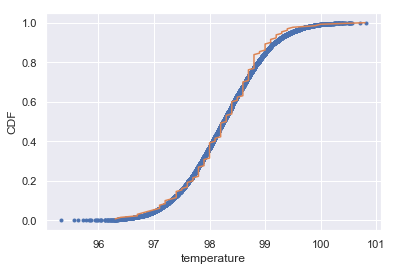

In [110]:
# Computing ECDF:

def ecdf(data):
    n=len(data)
    x=np.sort(data)
    y=np.arange(1, n+1)/n
    
    return x, y

x, y= ecdf(df['temperature'])
std = np.std(df['temperature'])
mean = np.mean(df['temperature'])

samples = np.random.normal(mean, std, size=10000)
x_test, y_test = ecdf(samples)

_ = plt.plot(x_test, y_test, marker='.', linestyle='none')
_ = plt.plot(x, y)
plt.xlabel('temperature')
plt.ylabel('CDF')
plt.show()

## 2: Is the sample size large? Are the observations independent?

The sample size is large, n=130 which is >= 30 (requirement for CLT). It also is < 10% of the population size (assuming population is at least 1300 hospital patients, city patients, etc)

The information does appear to be independent, as there is nothing to imply otherwise in the data (normal distribution, no unique id's, even distribution).

The dataframe has length: 130
The distribution appears even between M/F and independent of each person


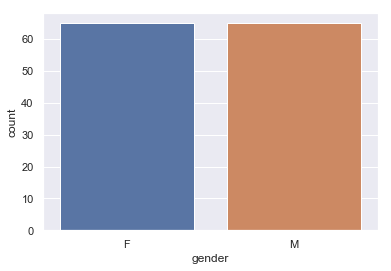

In [120]:
print('The dataframe has length:', len(df))
print('The distribution appears even between M/F and independent of each person')
sns.countplot(x='gender', data=df)

## 3: Is the true population mean really 98.6 degrees F?

### First, try a bootstrap hypothesis test.
The true population mean:
Testing mean body temperature
H0: μ = 98.6
Ha: μ!= 98.6

alpha = 0.05


In [121]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [124]:
bs_reps = draw_bs_reps(df['temperature'], np.mean, 10000)

# compute confidence interval
conf_int = np.percentile(bs_reps, (2.5, 97.5))
print('95% confidence interval =', conf_int)

# compute p-value
p = np.sum(bs_reps >= 98.6)/len(bs_reps)
print('p-value:', p)

95% confidence interval = [98.12230769 98.37463462]
p-value: 0.0


Because the p-value is less than the significance level (alpha=0.05), we can reject the null hypothesis. As such, the true population mean of the temperatures is different than 98.6.

We need to shift the data so that it has a mean equal to that of the hypothesis testing.

In [146]:
temp_mean = 98.6
temp_shifted = df.temperature - np.mean(df.temperature) + temp_mean

In [147]:
def diff_from_tempmean(data, tempmean=98.6):
    return np.mean(data) - tempmean

diff_obs = diff_from_tempmean(df.temperature)
print(diff_obs)

-0.35076923076921673


In [148]:
bs_replicates = draw_bs_reps(temp_shifted, diff_from_tempmean, 10000)
p = np.sum(bs_replicates <= diff_obs)/10000
print('p-value:', p)

p_value: 0.0


The bootstrap hypothesis test resulted in a p value less than the set alpha, 0.05 and the null hypthesis must be rejected and the actual mean is different.

### Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
For this, you would need to use a one sample test due to only having a single population's mean. 

### In this situation, is it appropriate to use the  tt  or  zz  statistic?
The sample size is over 30, so a z score would be appropriate

In [164]:
def ztest(data, mean=98.6):

    SE = np.std(data/np.sqrt(len(data)))
    Z = (np.mean(data)-mean)/SE
    p = stats.norm.cdf(Z)*2

    print('z-statistic:', Z)
    print('p-value:', p)

In [165]:
ztest(df.temperature)

z-statistic: -5.475925202078107
p-value: 4.352315165882405e-08


This means that a mean of 98.6 would only happen 5 standard deviations away from the population mean, which as the p-value shows, is nearly impossible.

### Now try using the other test. How is the result be different? Why?

In [158]:
t, p = stats.ttest_1samp(df['temperature'], 98.6)
print('t-statistic:', t)
print('p-value:', p)

t-statistic: -5.4548232923645195
p-value: 2.4106320415561276e-07


Because the sample is not under n=30 (like a t test expects), the p-value is slightly off.


## 4: Draw a small sample of size 10 from the data and repeat both frequentist tests.
### Which one is the correct one to use?
A t-test would be appropriate, having less than n=30 size

In [168]:
small_sample = np.random.choice(df['temperature'], 10)

ztest(small_sample)

t, p = stats.ttest_1samp(small_sample, 98.6)
print('t-statistic:', t)
print('p-value:', p)

z-statistic: -3.8581476071286698
p-value: 0.00011424964494645377
t-statistic: -3.660160196296528
p-value: 0.005234217099652249


### What do you notice? What does this tell you about the difference in application of the  tt and  zz  statist
As expected, the two tests returned different values. Because the sample size is much smaller, each iteration of the cell produces vastly different values, limiting the value from the test

## 5: At what temperature should we consider someone's temperature to be "abnormal"?

### As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach. Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.

### a: Bootstrapping

In [169]:
small_sample = draw_bs_reps(df['temperature'], np.mean, size=10000)

In [170]:
# Compute confidence interval
conf_int = np.percentile(small_sample, (2.5, 97.5))
print('95% confidence interval:', conf_int)

95% confidence interval: [98.12382692 98.37230769]


It appears that anyone below 98.12 or above 98.37 should be considered abnormal

### b: Frequentist

In [177]:
def margin_of_error(data):
    n=len(data)
    std=np.std(data)
    Z=1.96 # CI 95%
    MoE= Z* (std/np.sqrt(n))
    return MoE

In [181]:
MoE = margin_of_error(df.temperature)

print('Confidence interval:', np.mean(df.temperature)-MoE, '-', np.mean(df.temperature) + MoE)

Confidence interval: 98.12367980442819 - 98.37478173403336


Anyone below 98.12 or above 98.37 should be considered abnormal, exactly what we got with the bootstrap method.

## 6: Is there a significant difference between males and females in normal temperature?
### What testing approach did you use and why?

For this, we need a 2 sample t-test since there will be two populations to consider.

In [193]:
# create to df for each gender
men = df[df['gender'] == 'M']
women = df[df['gender'] == 'F']

print('male mean temp:', np.mean(men.temperature))
print('female mean temp:', np.mean(women.temperature))

male mean temp: 98.1046153846154
female mean temp: 98.39384615384613


### There is a clear difference between the mean temperature of men and women. Is it enough to be significant?

H0: female and male mean body temps are equal

Ha: female and male mean body temps are not equal

alpha = 0.05

In [195]:
stats.ttest_ind(men.temperature, women.temperature, equal_var=False)

Ttest_indResult(statistic=-2.285434538165611, pvalue=0.023938264182934196)

Because the p-value is 0.024, which is less than alpha 0.05, we reject the null hypthesis and accept that men and women have different means.

### Write a story with your conclusion in the context of the original problem.
The data being used was large enough to apply the Central Limit Theorem. This, combined with proving that the data is normally distributed, I tested out both bootstrapping and frequentist approach to the population temperature mean. I proved that it is not the traditionally thought 98.6, and that the more appropriate range would be between 98.1 and 98.4 about. To see if men and women had significantly different temperatures, a two sample test was performed which proved that there is a statistically significant different between their body temperatures.